# Bond Option Pricing Tree Convergence - Zero Vol

Value an option on a coupon paying bond using the Hull-White, Black-Derman-Toy and Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from financepy.finutils import *
from financepy.market.curves import *
from financepy.models.FinModelRatesBK import FinModelRatesBK
from financepy.models.FinModelRatesBDT import FinModelRatesBDT
from financepy.models.FinModelRatesHW import FinModelRatesHW
from financepy.products.bonds import *

####################################################################
# FINANCEPY BETA Version 0.191 - This build:  17 Jan 2021 at 18:30 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Set up the Discount Curve

In [2]:
settlementDate = FinDate(1, 12, 2019)

Set up discount curve

In [3]:
rate = 0.05
fixedFreq = FinFrequencyTypes.ANNUAL
discountCurve = FinDiscountCurveFlat(settlementDate, rate, fixedFreq)

## Setting up the Bond

In [4]:
issueDate = FinDate(1, 9, 2015)
maturityDate = FinDate(1, 9, 2025)
coupon = 0.06
frequencyType = FinFrequencyTypes.ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(issueDate, maturityDate, coupon, frequencyType, accrualType)
face = 100.0

## Setting up the Option

In [5]:
expiryDate = settlementDate.addTenor("18m")
print(expiryDate)

01-JUN-2021


Calculate the intrinsic

In [6]:
K = 102.0

In [7]:
df = discountCurve.df(expiryDate)

We consider European and American options. As the European has to be exercised on the expiry date, its intrinsic is easy to calculate. Th eAmerican may be exercised immediately if its clean price is moving against the option holder's payoff over time. So we calculate the spot intrinsic too. 

Spot price and forward price to get intrinsic

In [8]:
sp = bond.cleanPriceFromDiscountCurve(settlementDate, discountCurve)
fp = bond.cleanPriceFromDiscountCurve(expiryDate, discountCurve)

In [9]:
print("Spot Bond Price: %9.5f" % sp)
print("Forward Bond Price: %9.5f" % fp)

Spot Bond Price: 104.86938
Forward Bond Price: 103.71913


In [10]:
callIntrinsic = max(sp - K, 0)
putIntrinsic = max(K - sp, 0)

In [11]:
print("Call Intrinsic Spot: %9.5f" % callIntrinsic)
print("Put  Intrinsic Spot: %9.5f" % putIntrinsic)

Call Intrinsic Spot:   2.86938
Put  Intrinsic Spot:   0.00000


Forward bond price and PV of intrinsic

In [12]:
callIntrinsicPV = max(fp - K, 0) * df
putIntrinsicPV = max(K - fp, 0) * df

In [13]:
print("Call Intrinsic Fwd: %9.5f" % callIntrinsicPV)
print("Put  Intrinsic Fwd: %9.5f" % putIntrinsicPV)

Call Intrinsic Fwd:   1.59791
Put  Intrinsic Fwd:   0.00000


## Convergence Testing

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

We set the range of num steps.

In [14]:
numStepsVector = range(500, 1000, 1)

In [15]:
blackVol = 0.0001

## Hull-White Model

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [16]:
sigma = blackVol * rate
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    hwModel = FinModelRatesHW(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, hwModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, hwModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

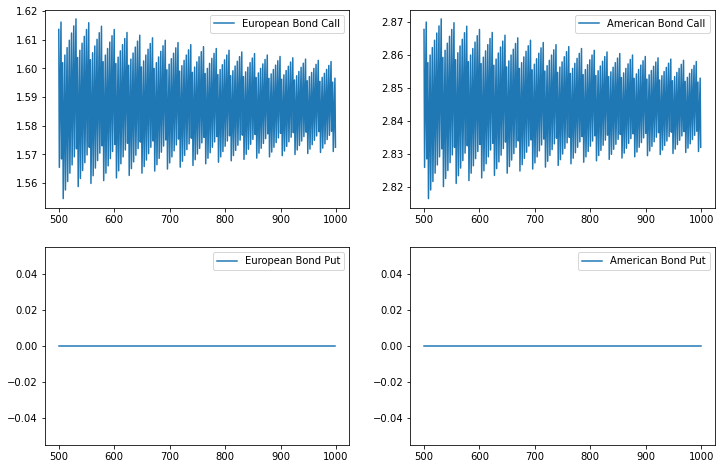

In [17]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

Convergence is good. 

## Black-Karasinski Model

In [18]:
sigma = blackVol
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bkModel = FinModelRatesBK(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bkModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bkModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

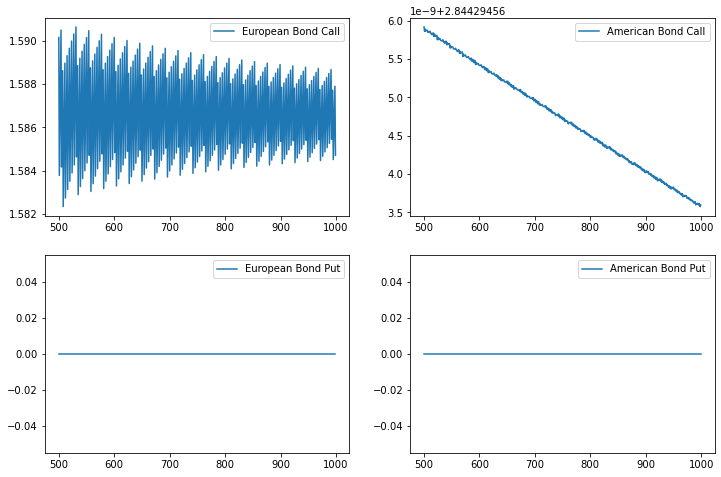

In [19]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

## Black-Derman-Toy Model


In [20]:
sigma = blackVol

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bdtModel = FinModelRatesBDT(sigma, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bdtModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bdtModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bdtModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bdtModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

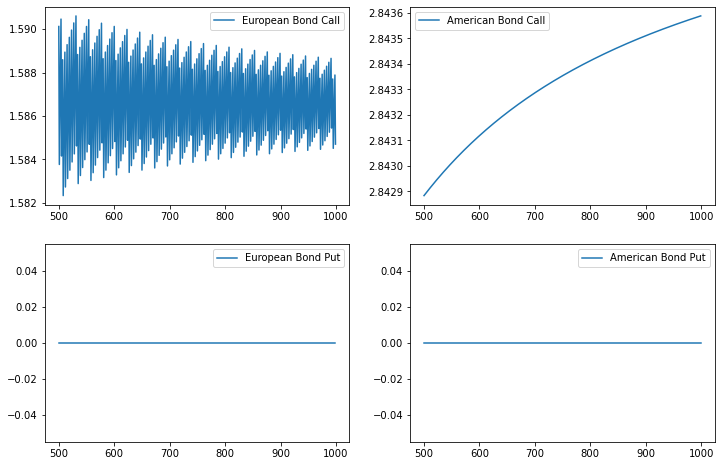

In [21]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

## Comments

European options are noisy due to calculating a forward price. Discounting and timing of the expiry date which is not on the grid exactly cause noise. The American is exercised now and as time 0 is on the grid it is noiseless.

A trick of averaging even and odd values would help convergence.

Copyright (c) Dominic O'Kane 2020